# Access satellite imagery using Python

Questions:
- Where can I find open satellite data?
- How do I search for satellite imagery with the STAC API?
- How do I fetch remote raster datasets using Python?

Objectives:
- Search public STAC repositories of satellite imagery using Python.
- Inspect the search result metadata.
- Download (a subset of) the assets available for a satellite scene.
- Open the satellite imagery as raster data and setup some raster calculations.
- Save the processed satellite data to disk.

## Search for satellite imagery

### The SpatioTemporal Asset Catalog (STAC) specification

### Search a STAC catalog

#### Exercise: Discover a STAC catalog
Let's take a moment to explore the Earth Search STAC catalog, which is a catalog listing few satellite image datasets that are hosted on AWS. The catalog is accessible via the STAC API at the following URL: [https://earth-search.aws.element84.com/v0](https://earth-search.aws.element84.com/v0). We can interactively browse a STAC catalog using the following tool: [https://radiantearth.github.io/stac-browser](https://radiantearth.github.io/stac-browser). Open the link in your web browser, paste the STAC API URL in the navigation bar, and click on "Load". Which collections are available? Open the Sentinel-2 L2A COGs collection, and select one of the items (i.e. a satellite "scene"). Have a look at the metadata fields and browse through the available assets. What type of data can you access for this item?

In [1]:
api_url = "https://earth-search.aws.element84.com/v0"

In [2]:
from pystac_client import Client

client = Client.open(api_url)

# collection: Sentinel-2, Level 2A, COGs
collection = "sentinel-s2-l2a-cogs"

# AMS coordinates
lat, lon = 52.37, 4.90
geometry = {"type": "Point", "coordinates": (lon, lat)}

mysearch = client.search(
    collections=[collection],
    intersects=geometry,
    max_items=10,
)

In [3]:
print(mysearch.matched())

614


In [4]:
items = mysearch.get_all_items()

In [5]:
print(len(items))

10


In [6]:
for item in items:
    print(item)

<Item id=S2A_31UFU_20220127_0_L2A>
<Item id=S2B_31UFU_20220125_0_L2A>
<Item id=S2B_31UFU_20220122_0_L2A>
<Item id=S2A_31UFU_20220120_0_L2A>
<Item id=S2A_31UFU_20220117_0_L2A>
<Item id=S2B_31UFU_20220115_0_L2A>
<Item id=S2B_31UFU_20220112_0_L2A>
<Item id=S2A_31UFU_20220110_0_L2A>
<Item id=S2A_31UFU_20220107_0_L2A>
<Item id=S2B_31UFU_20220105_0_L2A>


In [7]:
item = items[0]
print(item.datetime)
print(item.geometry)
print(item.properties)

2022-01-27 10:46:25+00:00
{'type': 'Polygon', 'coordinates': [[[6.071664488869862, 52.22257539160586], [4.815875241349358, 52.24858899598065], [5.241229024133816, 53.22854410990742], [6.1417542968794585, 53.20819279121764], [6.071664488869862, 52.22257539160586]]]}
{'datetime': '2022-01-27T10:46:25Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'gsd': 10, 'view:off_nadir': 0, 'proj:epsg': 32631, 'sentinel:utm_zone': 31, 'sentinel:latitude_band': 'U', 'sentinel:grid_square': 'FU', 'sentinel:sequence': '0', 'sentinel:product_id': 'S2A_MSIL2A_20220127T104321_N0400_R008_T31UFU_20220127T151103', 'sentinel:data_coverage': 66.5, 'eo:cloud_cover': 83.72, 'sentinel:valid_cloud_cover': True, 'sentinel:processing_baseline': '04.00', 'created': '2022-01-27T17:51:48.521Z', 'updated': '2022-01-27T17:51:48.521Z'}


#### Exercise: Search satellite scenes using metadata filters
Search for all the available Sentinel-2 scenes in the `sentinel-s2-l2a-cogs` collection that satisfy the following criteria:
- intersect a provided bounding box (use ±0.05 deg in lat/lon from the point: 52.37N 4.90E);
- have been recorded in 2021;
- have a cloud coverage smaller than 5%.

How many scenes are available? Save the search results in  GeoJSON format.

##### Solution

In [8]:
from shapely.geometry import Point
p = Point(lon, lat)
bbox = p.buffer(0.05).bounds

In [9]:
mysearch = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2021-01-01/2021-12-31",
    query=["eo:cloud_cover<5"]
)
print(mysearch.matched())

42


In [10]:
items = mysearch.get_all_items()
items.save_object("mysearch.json")

## Access the assets

In [11]:
assets = items[-1].assets  # last item's asset dictionary
print(assets.keys())

dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])


In [12]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [13]:
print(assets["thumbnail"].href)

https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FU/2021/1/12/0/preview.jpg


In [14]:
import rioxarray
visual_href = assets["visual"].href
visual = rioxarray.open_rasterio(visual_href)
print(visual)

<xarray.DataArray (band: 3, y: 10980, x: 10980)>
[361681200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0


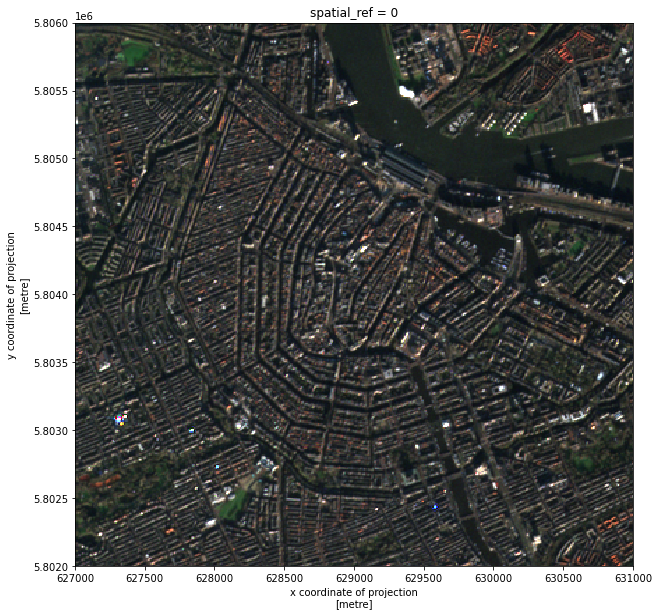

In [15]:
visual_clip = visual.rio.clip_box(
    minx=627000,
    miny=5802000,
    maxx=631000,
    maxy=5806000
)
visual_clip.plot.imshow(figsize=(10,10))

In [16]:
# save processed image to disk
visual_clip.rio.to_raster("amsterdam_tci.tif", driver="COG")

### Exercise: Downloading Landsat 8 Assets
In this exercise we put in practice all the skills we have learned in this episode to retrieve images from a different mission: [Landsat 8](https://www.usgs.gov/landsat-missions/landsat-8). Scenes from this satellite are also indexed in the Earth Search STAC catalog, so you can use the same endpoints used for Sentinel-2 for the following queries.

- Using `pystac_client`, search for all assets of the Landsat 8 collection (`landsat-8-l1-c1`) from February to March 2021, intersecting the point (40.78, -73.97).
- Select the scene with the lowest cloud cover, and open the panchromatic band (band 8, `B8`) using `rioxarray`.
- Make a cutout of the scene using the following bounding box: `(577000, 4504000, 597000, 4524000)`.
- Save the raster as a GeoTIFF file.

#### Solution

In [17]:
collection = "landsat-8-l1-c1"

# define point geometry
lat, lon = 40.78, -73.97
coords = dict(type="Point", coordinates=(lon, lat))

datetime="2021-02-01/2021-03-31"

# setup search
mysearch = client.search(
    collections=[collection],
    intersects=coords,
    datetime=datetime,
)

# retrieve search results
items = mysearch.get_all_items()
print(len(items))

7


In [18]:
items_sorted = sorted(items, key=lambda x: x.properties["eo:cloud_cover"])
item = items_sorted[0]
print(item)

<Item id=LC08_L1TP_013032_20210208_20210305_01_T1>


In [19]:
band_pan_href = item.assets["B8"].href
band_pan = rioxarray.open_rasterio(band_pan_href)
print(band_pan)

<xarray.DataArray (band: 1, y: 15561, x: 15321)>
[238410081 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.271e+05 5.271e+05 ... 7.569e+05 7.569e+05
  * y            (y) float64 4.582e+06 4.582e+06 ... 4.349e+06 4.349e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


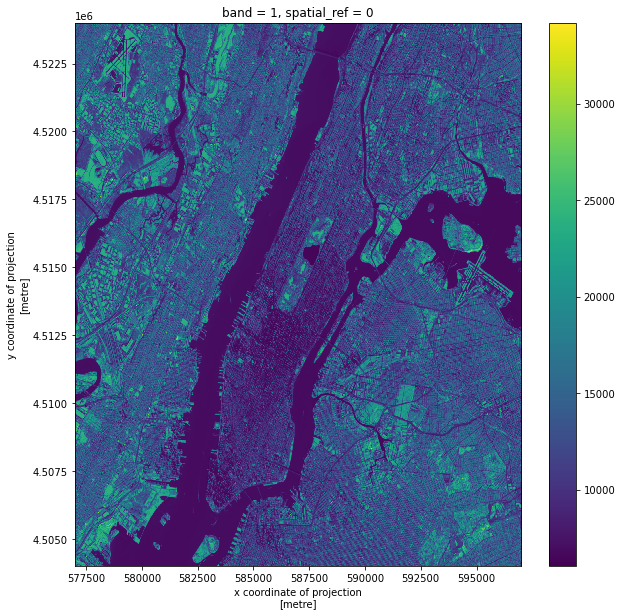

In [20]:
bbox = (577000, 4504000, 597000, 4524000)
band_pan_clip = band_pan.rio.clip_box(*bbox)
band_pan_clip.squeeze().plot.imshow(figsize=(10,10))

In [21]:
band_pan_clip.rio.to_raster("manhattan.tif", driver="COG")

Key-points:
- Accessing satellite images via the providers' API enables a more reliable and scalable data retrieval.
- STAC catalogs can be browsed and searched using the same tools and scripts.
- `rioxarray` also allows you to open and download remote raster files.